In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader, TensorDataset
from tabulate import tabulate
from transformers import BertTokenizer
from datasets import load_dataset

from tqdm import tqdm
import random

This is a template of the notebook that you should complete and enrich with your own code.

First cells will be the same than the ones of the lab on text convolution.

# Data loading


In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

Same celel than in the lab session.

🚧 **TODO** 🚧

Read the documentation about HuggingFace dataset and complete the code below.
You should:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [7]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["review_ids", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

document_train_set = splitted_dataset["train"]
document_valid_set = splitted_dataset["test"]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [8]:
def extract_words_contexts(ids_list, radius):
    words = []
    contexts = []

    # add padding with 0 to handle the borders
    padded_ids = [0] * radius + ids_list + [0] * radius

    for i, word_id in enumerate(ids_list):
        context = (
            padded_ids[i : i + radius] + padded_ids[i + radius + 1 : i + 2 * radius + 1]
        )

        words.append(word_id)
        contexts.append(context)

    return words, contexts

In [9]:
def flatten_dataset_to_list(dataset, radius):
    word_list = []
    context_list = []

    for example in dataset:
        words, contexts = extract_words_contexts(example["review_ids"], radius)
        word_list.extend(words)
        context_list.extend(contexts)

    return word_list, context_list

In [10]:
radius = 5
word_list_train, context_list_train = flatten_dataset_to_list(
    document_train_set, radius
)
word_list_valid, context_list_valid = flatten_dataset_to_list(
    document_valid_set, radius
)

In [11]:
word_list_train_tensor = torch.tensor(word_list_train)
context_list_train_tensor = torch.tensor(context_list_train)
word_list_valid_tensor = torch.tensor(word_list_valid)
context_list_valid_tensor = torch.tensor(context_list_valid)

train_set = TensorDataset(word_list_train_tensor, context_list_train_tensor)
valid_set = TensorDataset(word_list_valid_tensor, context_list_valid_tensor)

In [12]:
word_list_train_tensor

tensor([2023, 3185, 2003,  ..., 4268, 1998, 2031])

In [13]:
def collate_fn(batch, K):
    word_ids, positive_context_ids = zip(*batch)
    word_ids_tensor = torch.stack(word_ids)
    positive_context_ids_tensor = torch.stack(positive_context_ids)
    R = positive_context_ids_tensor.shape[1] // 2

    vocab = list(tokenizer.vocab.keys())
    negative_context_ids = []
    for _ in range(len(batch)):
        negative_words = random.sample(vocab, 2 * R * K)
        negative_context_ids.append(
            tokenizer.encode(negative_words, add_special_tokens=False)
        )
    negative_context_ids_tensor = torch.tensor(negative_context_ids)

    return {
        "word_id": word_ids_tensor,
        "positive_context_ids": positive_context_ids_tensor,
        "negative_context_ids": negative_context_ids_tensor,
    }

In [14]:
import functools

batch_size = 128
K = 10

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=functools.partial(collate_fn, K=K)
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=functools.partial(collate_fn, K=K)
)
n_valid = len(valid_set)
n_train = len(train_set)

In [15]:
n_valid, n_train

(205808, 825854)

In [16]:
# Assuming you have already defined train_dataloader and valid_dataloader


def print_batch_info(dataloader):
    for i, batch in enumerate(dataloader):
        if i == 3:  # Stop after 3 iterations
            break

        R = batch["positive_context_ids"].shape[1] // 2
        K = batch["negative_context_ids"].shape[1] // (2 * R)
        print(f"Batch {i+1}:")
        print(f"  R: {R}")
        print(f"  K: {K}")
        print(f"  Shape of word_id: {batch['word_id'].shape}")
        print(f"  Shape of positive_context_ids: {batch['positive_context_ids'].shape}")
        print(f"  Shape of negative_context_ids: {batch['negative_context_ids'].shape}")
        print()


# Print information for train DataLoader
print("Train DataLoader:")
print_batch_info(train_dataloader)

Train DataLoader:
Batch 1:
  R: 5
  K: 10
  Shape of word_id: torch.Size([128])
  Shape of positive_context_ids: torch.Size([128, 10])
  Shape of negative_context_ids: torch.Size([128, 100])

Batch 2:
  R: 5
  K: 10
  Shape of word_id: torch.Size([128])
  Shape of positive_context_ids: torch.Size([128, 10])
  Shape of negative_context_ids: torch.Size([128, 100])

Batch 3:
  R: 5
  K: 10
  Shape of word_id: torch.Size([128])
  Shape of positive_context_ids: torch.Size([128, 10])
  Shape of negative_context_ids: torch.Size([128, 100])



# Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [17]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, word_ids, context_ids):
        word_vectors = self.target_embeddings(word_ids)
        context_vectors = self.context_embeddings(context_ids)
        dot_products = torch.sum(word_vectors * context_vectors, dim=1)
        outputs = torch.sigmoid(dot_products)
        return outputs

In [18]:
def train(model, data_loader, optimizer, device, epochs):
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for batch in data_loader:
            word_ids = batch["word_id"].to(device)
            pos_context_ids = batch["positive_context_ids"].to(device)
            neg_context_ids = batch["negative_context_ids"].to(device)

            optimizer.zero_grad()
            loss = 0

            for i in range(pos_context_ids.size(1)):
                pos_predictions = model(word_ids, pos_context_ids[:, i])
                pos_labels = torch.ones(pos_predictions.shape, device=device)
                loss += F.binary_cross_entropy(pos_predictions, pos_labels)

            for i in range(neg_context_ids.size(1)):
                neg_predictions = model(word_ids, neg_context_ids[:, i])
                neg_labels = torch.zeros(neg_predictions.shape, device=device)
                loss += F.binary_cross_entropy(neg_predictions, neg_labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}")

In [19]:
for i in train_dataloader:
    print(len(i["word_id"]))
    break

128


In [20]:
@torch.no_grad()
def evaluate(model, data_loader, loss_vector, accuracy_vector, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in data_loader:
        word_ids = batch["word_id"].to(device)
        pos_context_ids = batch["positive_context_ids"].to(device)
        neg_context_ids = batch["negative_context_ids"].to(device)

        loss = 0

        for i in range(pos_context_ids.size(1)):
            pos_predictions = model(word_ids, pos_context_ids[:, i])
            pos_labels = torch.ones(pos_predictions.shape, device=device)
            loss += F.binary_cross_entropy(pos_predictions, pos_labels)
            # Accuracy
            correct_predictions += (
                ((pos_predictions > 0.5).int() == pos_labels).sum().item()
            )
            total_predictions += pos_labels.size(0)

        for i in range(neg_context_ids.size(1)):
            neg_predictions = model(word_ids, neg_context_ids[:, i])
            neg_labels = torch.zeros(neg_predictions.shape, device=device)
            loss += F.binary_cross_entropy(neg_predictions, neg_labels)
            # Accuracy
            correct_predictions += (
                ((neg_predictions > 0.5).int() == neg_labels).sum().item()
            )
            total_predictions += neg_labels.size(0)

        total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    loss_vector.append(average_loss)

    accuracy = 100.0 * correct_predictions / total_predictions
    accuracy_vector.append(accuracy)
    print(f"Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

In [ ]:
d = 128
vocab_size = len(tokenizer.vocab)
model = Word2Vec(vocab_size, d).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 3
loss_vector, accuracy_vector = [], []

for epoch in range(1, epochs + 1):
    train(model, train_dataloader, optimizer, device, epoch)
    evaluate(model, valid_dataloader, loss_vector, accuracy_vector, device)

100%|██████████| 1/1 [12:21<00:00, 741.96s/it]

Epoch 1/1, Average Loss: 339.2507


Average Loss: 106.0107, Accuracy: 88.7426


 50%|█████     | 1/2 [12:20<12:20, 740.50s/it]

Epoch 1/2, Average Loss: 62.3035


100%|██████████| 2/2 [24:44<00:00, 742.01s/it]

Epoch 2/2, Average Loss: 31.4469


Average Loss: 30.7414, Accuracy: 94.7221


 33%|███▎      | 1/3 [12:42<25:25, 762.65s/it]

Epoch 1/3, Average Loss: 22.1924


 67%|██████▋   | 2/3 [25:07<12:32, 752.12s/it]

Epoch 2/3, Average Loss: 18.0068


100%|██████████| 3/3 [37:35<00:00, 751.78s/it]

Epoch 3/3, Average Loss: 15.6704


Average Loss: 20.7135, Accuracy: 95.6140


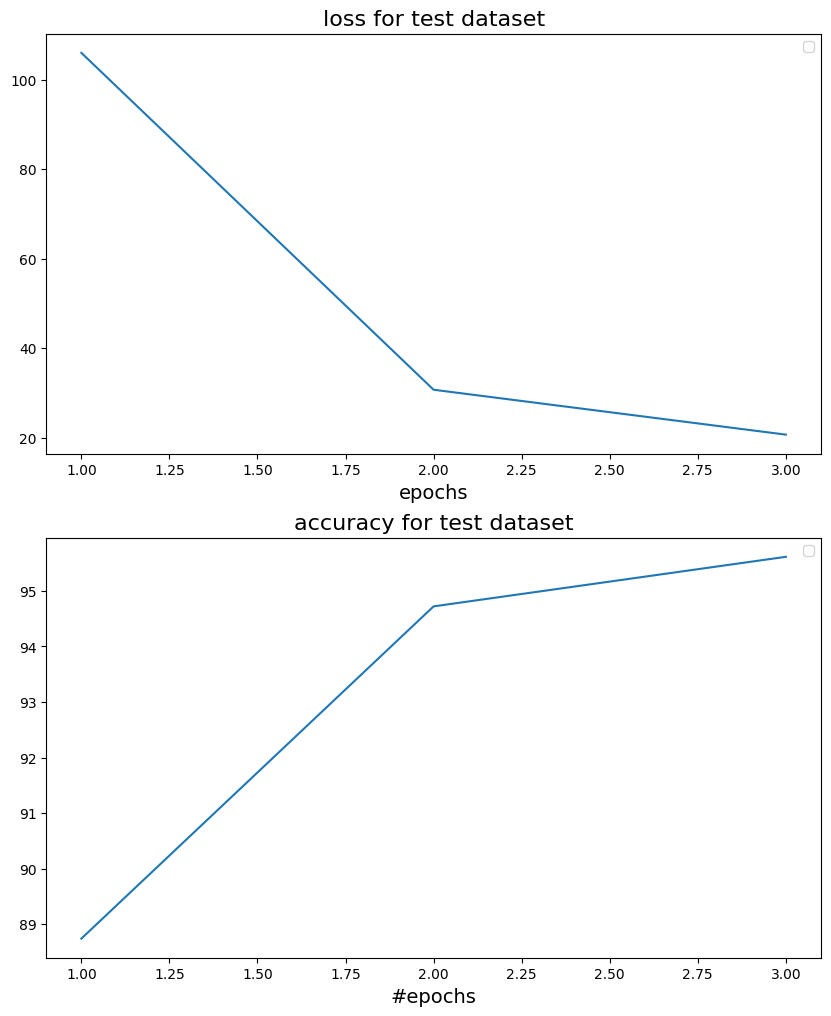

In [ ]:
import matplotlib.pyplot as plt

epochs = 1 + np.arange(3)

plt.figure(figsize=(10, 12))
plt.subplot(211)
plt.plot(epochs, loss_vector)
plt.title("loss for test dataset", fontsize=16)
plt.xlabel("epochs", fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(epochs, accuracy_vector)
plt.title("accuracy for test dataset", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.legend()

In [ ]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    f"model_dim-{d}_radius-{radius}_ratio-{K}-batch-{batch_size}-epoch-{epochs}.ckpt",
)

In [21]:
d = 128
epochs = 3
vocab_size = len(tokenizer.vocab)

In [24]:
a = Word2Vec(vocab_size, d).to(device)
optimizer = torch.optim.Adam(a.parameters(), lr=0.001)


checkpoint_path = (
    f"model_dim-{d}_radius-{radius}_ratio-{K}-batch-{batch_size}-epoch-{epochs}.ckpt"
)
checkpoint = torch.load(checkpoint_path)

a.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [25]:
checkpoint["model_state_dict"]["target_embeddings.weight"]

tensor([[-0.8164, -1.8086, -0.2585,  ...,  0.3218,  1.3779,  1.9839],
        [ 0.5547, -0.1768, -0.6410,  ...,  1.2029,  0.7170,  0.9704],
        [ 2.3724,  1.7655,  1.0317,  ..., -0.1261,  0.4322,  0.0732],
        ...,
        [ 0.5051,  0.8415, -0.1019,  ...,  0.7771, -0.1141,  0.8671],
        [ 1.4319, -0.2463, -0.6324,  ..., -1.0415, -0.7991,  0.4300],
        [ 1.1897, -0.3364,  0.3969,  ...,  1.4031,  0.9737,  1.0727]],
       device='cuda:0')

In [26]:
a.target_embeddings.weight.data

tensor([[-0.8164, -1.8086, -0.2585,  ...,  0.3218,  1.3779,  1.9839],
        [ 0.5547, -0.1768, -0.6410,  ...,  1.2029,  0.7170,  0.9704],
        [ 2.3724,  1.7655,  1.0317,  ..., -0.1261,  0.4322,  0.0732],
        ...,
        [ 0.5051,  0.8415, -0.1019,  ...,  0.7771, -0.1141,  0.8671],
        [ 1.4319, -0.2463, -0.6324,  ..., -1.0415, -0.7991,  0.4300],
        [ 1.1897, -0.3364,  0.3969,  ...,  1.4031,  0.9737,  1.0727]],
       device='cuda:0')

### 3.3 Classification task

In [72]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

In [73]:
data_collator = DataCollator(tokenizer)

batch_size = 128

train_dataloader = DataLoader(
    document_train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    document_valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(document_valid_set)
n_train = len(document_train_set)

In [74]:
# Conv1dClassifier
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embl = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, feature_size, kernel_size=kernel_size)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.lin = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids):
        embs = self.embl(input_ids)
        tmp = self.conv(embs.mT)
        tmp = self.pool(tmp).squeeze()
        logit = self.lin(tmp)
        return self.out_activation(logit)

In [75]:
def load_model(embeddings_path, model, freeze=True):
    embeddings = torch.load(embeddings_path)

    model.embl.weight.data.copy_(
        embeddings["model_state_dict"]["target_embeddings.weight"]
    )
    if freeze:
        model.embl.weight.requires_grad = False

In [76]:
model = Conv1dClassifier(vocab_size=vocab_size, embedding_dim=d)
model.to(device)
model.embl.weight.data

tensor([[ 0.2832,  0.0178, -0.0669,  ..., -0.7134,  0.1949, -0.0642],
        [ 0.6117,  0.8324, -0.0378,  ..., -0.1871,  0.8263, -0.6621],
        [ 1.0477, -0.7859,  1.3120,  ...,  1.2930, -0.7187, -1.6313],
        ...,
        [ 1.6648,  0.6178,  2.1037,  ..., -2.0326,  0.6351,  0.2964],
        [ 0.1095,  0.6783,  0.0384,  ...,  0.1937,  0.4877, -1.3630],
        [ 0.4583, -0.5880, -0.6124,  ...,  0.8938, -0.8939, -0.1687]],
       device='cuda:0')

In [77]:
def train_class(model, data_loader, optimizer, device, epochs):
    loss_function = nn.BCELoss().to(device)
    model.train()

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        correct = 0
        total_samples = 0

        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            probs = model(batch["review_ids"])
            gold = batch["label"]
            pred = (probs > 0.5).int()
            correct += (gold == pred).sum().item()
            loss = loss_function(probs, gold.float())

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_samples += gold.size(0)

        average_loss = total_loss / len(data_loader)
        accuracy = 100.0 * correct / total_samples
        print(
            f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}"
        )

    return average_loss, accuracy

In [78]:
@torch.no_grad()
def evaluate_class(model, data_loader, loss_vector, accuracy_vector, device):
    loss_function = nn.BCELoss().to(device)
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    for batch in data_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        probs = model(batch["review_ids"])
        gold = batch["label"]
        pred = (probs > 0.5).int()
        correct += (gold == pred).sum().item()
        loss = loss_function(probs, gold.float())

        total_loss += loss.item()
        total_samples += gold.size(0)

    average_loss = total_loss / len(data_loader)
    loss_vector.append(average_loss)
    accuracy = 100.0 * correct / total_samples
    accuracy_vector.append(accuracy)

    print(f"Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")
    return average_loss, accuracy

## Training the model without this initialization

In [79]:
model = Conv1dClassifier(vocab_size=vocab_size, embedding_dim=d)
model.to(device)
model.embl.weight.data

tensor([[-0.5044, -0.9945, -1.0980,  ...,  0.3185, -0.0374, -0.5801],
        [ 0.6942,  0.5472, -2.0802,  ...,  0.2976,  0.3946,  0.2209],
        [-0.0236,  0.5545, -0.3436,  ...,  0.0985,  0.7949, -0.1549],
        ...,
        [-1.4264,  0.4702,  0.4937,  ...,  1.2717,  0.6297,  0.4694],
        [-1.0344,  1.4808, -0.5253,  ...,  1.0923, -0.5353,  1.1893],
        [-0.1133, -0.6026, -0.6176,  ..., -0.8578,  1.1683, -0.4005]],
       device='cuda:0')

In [80]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
loss_vector, accuracy_vector = [], []

for epoch in range(1, epochs + 1):
    train_class(model, train_dataloader, optimizer, device, 1)
    evaluate_class(model, valid_dataloader, loss_vector, accuracy_vector, device)

100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Epoch 1/1, Average Loss: 0.6770, Accuracy: 57.9500


Average Loss: 0.6593, Accuracy: 62.4000


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

Epoch 1/1, Average Loss: 0.5829, Accuracy: 73.2750


Average Loss: 0.6148, Accuracy: 68.5000


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

Epoch 1/1, Average Loss: 0.5076, Accuracy: 80.5000


Average Loss: 0.5680, Accuracy: 73.6000


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

Epoch 1/1, Average Loss: 0.4369, Accuracy: 84.9750


Average Loss: 0.5346, Accuracy: 75.3000


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Epoch 1/1, Average Loss: 0.3747, Accuracy: 88.3750


Average Loss: 0.5136, Accuracy: 74.6000


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Epoch 1/1, Average Loss: 0.3197, Accuracy: 91.6750


Average Loss: 0.5016, Accuracy: 75.2000


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

Epoch 1/1, Average Loss: 0.2709, Accuracy: 94.0000


Average Loss: 0.4963, Accuracy: 75.4000


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Epoch 1/1, Average Loss: 0.2278, Accuracy: 95.8500


Average Loss: 0.4948, Accuracy: 75.8000


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

Epoch 1/1, Average Loss: 0.1902, Accuracy: 97.2500


Average Loss: 0.4933, Accuracy: 76.4000


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Epoch 1/1, Average Loss: 0.1579, Accuracy: 98.0750


Average Loss: 0.4869, Accuracy: 77.0000


## Training the model after  loads the checkpoint the embeddings

In [81]:
model = Conv1dClassifier(vocab_size=vocab_size, embedding_dim=d)
model.to(device)
load_model(checkpoint_path, model)
model.embl.weight

Parameter containing:
tensor([[-0.8164, -1.8086, -0.2585,  ...,  0.3218,  1.3779,  1.9839],
        [ 0.5547, -0.1768, -0.6410,  ...,  1.2029,  0.7170,  0.9704],
        [ 2.3724,  1.7655,  1.0317,  ..., -0.1261,  0.4322,  0.0732],
        ...,
        [ 0.5051,  0.8415, -0.1019,  ...,  0.7771, -0.1141,  0.8671],
        [ 1.4319, -0.2463, -0.6324,  ..., -1.0415, -0.7991,  0.4300],
        [ 1.1897, -0.3364,  0.3969,  ...,  1.4031,  0.9737,  1.0727]],
       device='cuda:0')

In [82]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
loss_vector, accuracy_vector = [], []

for epoch in range(1, epochs + 1):
    train_class(model, train_dataloader, optimizer, device, 1)
    evaluate_class(model, valid_dataloader, loss_vector, accuracy_vector, device)

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

Epoch 1/1, Average Loss: 0.6954, Accuracy: 52.0000


Average Loss: 0.6863, Accuracy: 54.9000


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

Epoch 1/1, Average Loss: 0.6468, Accuracy: 72.0250


Average Loss: 0.6816, Accuracy: 56.3000


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Epoch 1/1, Average Loss: 0.6097, Accuracy: 82.9250


Average Loss: 0.6751, Accuracy: 58.8000


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Epoch 1/1, Average Loss: 0.5694, Accuracy: 86.7500


Average Loss: 0.6682, Accuracy: 60.5000


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

Epoch 1/1, Average Loss: 0.5228, Accuracy: 90.2250


Average Loss: 0.6610, Accuracy: 62.1000


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

Epoch 1/1, Average Loss: 0.4708, Accuracy: 93.2000


Average Loss: 0.6557, Accuracy: 62.4000


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

Epoch 1/1, Average Loss: 0.4162, Accuracy: 96.0750


Average Loss: 0.6503, Accuracy: 63.1000


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

Epoch 1/1, Average Loss: 0.3624, Accuracy: 98.1500


Average Loss: 0.6463, Accuracy: 63.5000


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Epoch 1/1, Average Loss: 0.3124, Accuracy: 98.8250


Average Loss: 0.6443, Accuracy: 63.0000


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

Epoch 1/1, Average Loss: 0.2669, Accuracy: 99.4000


Average Loss: 0.6443, Accuracy: 63.5000
